In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import os

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing.image import ImageDataGenerator
from keras.layers import Dense,Input,Dropout,GlobalAveragePooling2D,Flatten,Conv2D,BatchNormalization,Activation,MaxPooling2D
from keras.models import Model,Sequential
from keras.optimizers import Adam,SGD,RMSprop

In [2]:
picture_size = 48  
#standardising the size of each picture to be 48x48
folder_path = "images/"

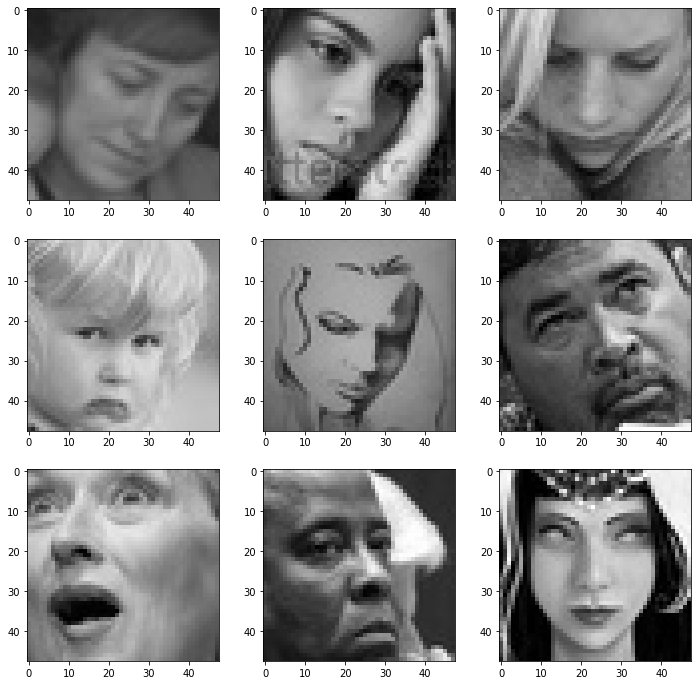

In [4]:
expression = 'sad'

plt.figure(figsize= (12,12))
for i in range(1, 10, 1):
    plt.subplot(3,3,i)
    img = load_img(folder_path+"train/"+expression+"/"+
                  os.listdir(folder_path + "train/" + expression)[i], target_size=(picture_size, picture_size))
    plt.imshow(img)   
plt.show()

Making Training and Validation Data

In [8]:
batch_size  = 64

train_data_dir = 'images/train/'
validation_data_dir = 'images/validation/'

datagen_train  = ImageDataGenerator(rescale=1./255,rotation_range=30,shear_range=0.3,zoom_range=0.3,horizontal_flip=True,fill_mode='nearest')
datagen_val = ImageDataGenerator(rescale=1./255)

train_set = datagen_train.flow_from_directory(train_data_dir,
                                              target_size = (picture_size,picture_size),
                                              color_mode = "grayscale",
                                              batch_size=batch_size,
                                              class_mode='categorical',
                                              shuffle=True)


test_set = datagen_val.flow_from_directory(validation_data_dir,
                                           target_size = (picture_size,picture_size),
                                           color_mode = "grayscale",
                                           batch_size=batch_size,
                                           class_mode='categorical',
                                           shuffle=False)

Found 28821 images belonging to 7 classes.
Found 7066 images belonging to 7 classes.


# Model Building

In [6]:
from keras.optimizers import Adam,SGD,RMSprop

no_of_classes = 7

model = Sequential()

#Batch Normalization is added in each layer to normalize the activations of the previous layer.
#This is done to avoid covariate shift problem.

#1st CNN layer
model.add(Conv2D(64,(3,3),padding = 'same',input_shape = (48,48,1)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout(0.25))

#2nd CNN layer
model.add(Conv2D(128,(5,5),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#3rd CNN layer
model.add(Conv2D(512,(3,3),padding = 'same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size = (2,2)))
model.add(Dropout (0.25))

#4th CNN layer
model.add(Conv2D(512,(3,3), padding='same'))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())

#Fully connected 1st layer
model.add(Dense(256))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Fully connected layer 2nd layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.25))

model.add(Dense(no_of_classes, activation='softmax'))

opt = Adam(lr = 0.0001)
model.compile(optimizer=opt,loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 48, 48, 64)        640       
                                                                 
 batch_normalization (BatchN  (None, 48, 48, 64)       256       
 ormalization)                                                   
                                                                 
 activation (Activation)     (None, 48, 48, 64)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 24, 24, 64)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 24, 24, 64)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 24, 24, 128)       2

C:\Users\91886\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


# Training of the model with train and validation set

In [11]:
train_set.n

28821

In [10]:
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, CSVLogger

epochs = 48
checkpoint_dir = 'results'

checkpoint_callback = ModelCheckpoint(filepath=os.path.join(checkpoint_dir,"model_epoch_{epoch}.h5"),
                                     save_weights_only=True,
                                     monitor='val_loss',
                                     verbose=1,
                                     mode='min')

early_stopping_callback = EarlyStopping(patience=3,verbose=1)

log_csv = CSVLogger('results/results.csv')

reduce_lr = ReduceLROnPlateau()

callbacks_list = [early_stopping_callback,checkpoint_callback,log_csv,reduce_lr]

model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001),
              metrics=['accuracy'])

C:\Users\91886\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\optimizers\legacy\adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [12]:
history = model.fit(train_set,
                    steps_per_epoch=train_set.n//batch_size,
                    epochs=epochs,
                    validation_data = test_set,
                    validation_steps = test_set.n//batch_size,
                    callbacks=callbacks_list)

Epoch 1/48
450/450 [==============================] - ETA: 0s - loss: 1.8884 - accuracy: 0.2451
Epoch 1: saving model to results\model_epoch_1.h5
450/450 [==============================] - 939s 2s/step - loss: 1.8884 - accuracy: 0.2451 - val_loss: 1.8255 - val_accuracy: 0.2199 - lr: 0.0010
Epoch 2/48
450/450 [==============================] - ETA: 0s - loss: 1.7011 - accuracy: 0.3241
Epoch 2: saving model to results\model_epoch_2.h5
450/450 [==============================] - 595s 1s/step - loss: 1.7011 - accuracy: 0.3241 - val_loss: 1.6595 - val_accuracy: 0.3631 - lr: 0.0010
Epoch 3/48
450/450 [==============================] - ETA: 0s - loss: 1.5551 - accuracy: 0.3945
Epoch 3: saving model to results\model_epoch_3.h5
450/450 [==============================] - 595s 1s/step - loss: 1.5551 - accuracy: 0.3945 - val_loss: 1.4711 - val_accuracy: 0.4294 - lr: 0.0010
Epoch 4/48
450/450 [==============================] - ETA: 0s - loss: 1.4443 - accuracy: 0.4390
Epoch 4: saving model to result

Plotting graphs

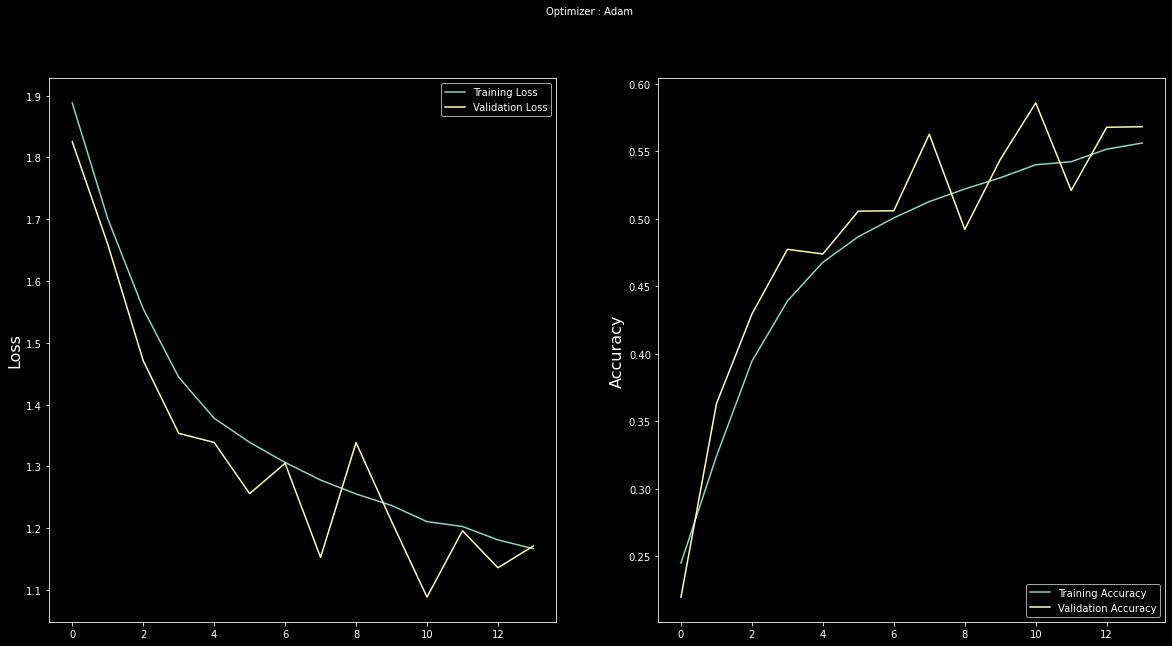

In [13]:
plt.style.use('dark_background')

plt.figure(figsize=(20,10))
plt.subplot(1, 2, 1)
plt.suptitle('Optimizer : Adam', fontsize=10)
plt.ylabel('Loss', fontsize=16)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend(loc='upper right')

plt.subplot(1, 2, 2)
plt.ylabel('Accuracy', fontsize=16)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend(loc='lower right')
plt.show()

In [15]:
model.save('main_model.h5')